# Figure 06

Visualisation of the small biases on demographic history, which can appear. We used the mostfreq and pairwise sample approach.

## Import libraries

In [1]:
import glob
import gzip
import os
import pickle
import re
import string
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from calc_coalescence_densities import *
from travelling_wave_approach import *

print(imported())

True


## Parameters and functions

In [2]:
# parameters to calculate the expected times
time_parameters = dict(tmin=0, tmax=13_000, ndens=300)
assert time_parameters["tmin"] == 0, "Present time must be set to zero!"
time_full = np.arange(time_parameters["tmin"], time_parameters["tmax"])
time_psi = np.array(
    [time_parameters["tmin"]]
    + list(
        np.logspace(
            np.log10(1), np.log10(time_full.max()), num=time_parameters["ndens"]
        )
    )
)

In [3]:
def extract_values(filename):
    fsplit = re.split(r"/|_|,", filename.split(".gzip")[0])
    return tuple(
        map(
            float,
            [
                fsplit[fsplit.index("popsize") + 1],
                fsplit[fsplit.index("delmutrate") + 1],
                fsplit[fsplit.index("selcoeff") + 1],
            ],
        )
    )

In [4]:
def colname_prep(my_colname):
    pattern = r"({[^}]+})_p([0-9.]+(?:e[+-]?\d+)?)_(\w+)"
    sampling_scheme_, sampling_prob_, stattype = [re.match(pattern, my_colname).group(_) for _ in range(1, 4)]
    sampling_scheme, sampling_prob = eval(sampling_scheme_), float(sampling_prob_)
    del sampling_scheme_, sampling_prob_
    
    df = dict(
        statistic = stattype,
        sampling_scheme = sampling_scheme,
        p = sampling_prob
    )

    return df

In [5]:
def analyse_demographic_type(demography: pd.Series, time_threshold: float = 4000, remove_leading_inf=True):
    """Categorizing the demography (Fwd-in-time perspective)"""
    # Remove leading 'inf' values
    if remove_leading_inf:
        demography = demography[demography.ne(np.inf).cumsum() > 0]
    
    time = demography.index
    demography = demography.to_numpy()[time <= time_threshold]
    dgrad = np.gradient(demography)
    signs = np.sign(dgrad)
    if all(signs == 0):
        warnings.warn(f"All gradients are zero: {all(signs == 0)}")
    
    diffs = np.diff(signs)
    number_sign_changes = np.count_nonzero(diffs)
    a = signs[0]  # first sign; direction of the gradient at present


    if all(np.isclose(dgrad, 0)):
        demographic_type = "Constant"
    elif a < 0 and number_sign_changes == 2:
        demographic_type = "Bottleneck"
    elif a < 0 and number_sign_changes == 1:
        demographic_type = "Bottleneck-like"
    elif a > 0 and number_sign_changes == 1:
        demographic_type = "Local-bias"
    elif a > 0 and number_sign_changes == 0:
        demographic_type = "Crash"
    elif a < 0 and number_sign_changes == 0:
        demographic_type = "Expansion"
    else:
        demographic_type = "Other"

    
    return demographic_type

In [6]:
def analyse_sampling_scheme(my_sampling_scheme):
    """
    {'pop_23': 2} --> mean=23, dist=0
    {'pop_6': 1, 'pop_12': 1} --> mean=9.0, dist=6
    """
    sampling_load = []
    for k, v in my_sampling_scheme.items():
        for _ in range(v):
            k_ = int(round(float(k.split("_")[1])))
            sampling_load.append(k_)
    assert len(sampling_load) == 2, "You have sampled more than a pair, this should not have happened!"
    load_mean_ = np.mean(sampling_load)
    load_dist_ = max(sampling_load) - min(sampling_load)

    return load_mean_, load_dist_

In [7]:
def pairsam_bias(file, time_threshold: float = 4000):
    f = file
    N_, U_, s_ = extract_values(f)
    df = pd.read_pickle(f)

    # separate coaldens and demography
    colid_popsize = []
    colid_coaldens = []
    colid_p, colid_p_2 = [], []
    demographic_type = []
    load_mean, load_dist = [], []
    
    
    for colid, col in enumerate(df.columns):
        colprop = colname_prep(col)
        if colprop["statistic"] == "popsize":
            colid_popsize.append(colid)
            colid_p.append(colprop["p"])
            demographic_type.append(analyse_demographic_type(df[col], time_threshold=time_threshold))
            a_, b_ = analyse_sampling_scheme(colprop["sampling_scheme"])
            load_mean.append(a_)
            load_dist.append(b_)
        elif colprop["statistic"] == "coaldens":
            colid_coaldens.append(colid)
            colid_p_2.append(colprop["p"])
        else:
            sys.exit(f"Unknown statistic name: {colprop['statistic']}")

    assert (np.array(colid_p) == np.array(colid_p_2)).all(), "Popsize and coaldens data not respective!"
    del colid_p_2
    df_popsize = df.iloc[:, colid_popsize]
    df_coaldens = df.iloc[:, colid_coaldens]

    return N_, s_, U_, colid_popsize, colid_coaldens, colid_p, demographic_type, load_mean, load_dist, df_popsize, df_coaldens

## Data and processing

### Mostfreq

In [8]:
path = "pipeline_data_figure6/v01/results/mostfreq/*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
# print(np.array(sorted_filenames))
_ = [print(_, __) for _, __ in enumerate(sorted_filenames, start=1)]

1 pipeline_data_figure6/v01/results/mostfreq/popsize_5000,delmutrate_0.006,selcoeff_1e-4.gzip
2 pipeline_data_figure6/v01/results/mostfreq/popsize_5000,delmutrate_0.006,selcoeff_4e-4.gzip
3 pipeline_data_figure6/v01/results/mostfreq/popsize_5000,delmutrate_0.006,selcoeff_1e-2.gzip


In [9]:
_N_list, _s_list, _U_list = [], [], []
df_popsize_list, df_coaldens_list = [], []

for fid, f in enumerate(sorted_filenames):
    N_, U_, s_ = extract_values(f)
    _N_list.append(N_)
    _s_list.append(s_)
    _U_list.append(U_)
    
    with gzip.open(f, "rb") as file:
        df_dict = pickle.load(file)
    df_popsize, df_coaldens = df_dict.get("popsize"), df_dict.get("coaldens")

    df_popsize_list.append(df_popsize)
    df_coaldens_list.append(df_coaldens)
    
    del df_dict

In [10]:
# get the stepping-stone-model predictions for the corresponding parameters (see figure 5)
path = "pipeline_data_figure6/v01/results/table/*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
_ = [print(_, __) for _, __ in enumerate(sorted_filenames, start=1)]

1 pipeline_data_figure6/v01/results/table/popsize_5000,delmutrate_0.006,selcoeff_1e-4.gzip
2 pipeline_data_figure6/v01/results/table/popsize_5000,delmutrate_0.006,selcoeff_4e-4.gzip
3 pipeline_data_figure6/v01/results/table/popsize_5000,delmutrate_0.006,selcoeff_1e-2.gzip


In [11]:
# get simulated click rates, profiles and predict Ne, coalrate under the stepping stone coalescence
click_rate_list, profile_list = [], []
effective_popsize_stepstone_list = []
coal_dens_stepstone_list = []

for fid, f in enumerate(sorted_filenames):
    N_, U_, s_ = extract_values(f)
    assert N_ == _N_list[fid], f"parameters not in same order or missing: {fid}"
    assert s_ == _s_list[fid], f"parameters not in same order or missing: {fid}"
    assert U_ == _U_list[fid], f"parameters not in same order or missing: {fid}"

    print(f"{fid+1}.) {N_}, {U_}, {s_}")

    df = pd.read_pickle(f)

    # assert the random number seed
    assert all(
        len(df[_].unique()) == 1 for _ in ("N", "s", "U")
    ), "Your table is not unique on the parameters"
    assert (
        not df["rng_seed"].duplicated().any()
    ), "You reused the same rng_seed for your simulation"

    # get click_rate
    click_rate = df["click_rate"]

    # get profiles
    max_length = df["profile"].apply(len).max()
    profile = pd.DataFrame(
        df["profile"]
        .apply(lambda x: np.pad(x, (0, max_length - len(x)), "constant"))
        .to_list(),
        columns=range(max_length),
    )

    click_rate_list.append(click_rate.mean())
    profile_list.append(profile.apply(np.mean, axis=0))  # get the mean of all simulated

    del df,  s_, click_rate, profile


    # calculate Ne and coalrate
    click_rate_ = click_rate_list[-1]
    profile_ = profile_list[-1]

    assert np.isclose(
        profile_.sum(), 1
    ), f"The profile does not sum up to one: {profile_.sum()}"

    # calculate migration matrix
    if click_rate_ < 0:
        warnings.warn(
            f"click rate is smaller 0 (v={click_rate_})"
            + "\nclick rate has been set to 0"
        )
        click_rate_ = 0
    elif click_rate_ > 1:
        warnings.warn(
            f"click rate is larger 1 ({click_rate_})" + "\nclick rate has been set to 1"
        )
        click_rate_ = 1
    else:
        pass

    migmat_ = create_bwd_migration_matrix(
        parameters={
            "fitness_class_freqs": profile_,
            "deleterious_mutation_rate": U_,
            "number_fitness_classes": len(profile_),
            "selcoef": None,  # not needed for mode Udv
            "wave_velocity": click_rate_,
        },
        mode="Udv",
    )

    # lineage weight distribution
    pkt_ = expected_lineage_weight_distribution_linalg(time_full, profile_, migmat_)

    # effective population size
    effective_popsize_ = np.array(
        [effective_population_size_manually(pkt_[t], N_, profile_) for t in time_full]
    )

    # coalescence density
    coal_dens_ = expected_coalescence_time_distribution(
        time_full, effective_popsize_, time_steps_coalescence=time_psi
    )

    # append results to list
    effective_popsize_stepstone_list.append(effective_popsize_)
    coal_dens_stepstone_list.append(coal_dens_)

    del migmat_, pkt_, effective_popsize_, coal_dens_

1.) 5000.0, 0.006, 0.0001
2.) 5000.0, 0.006, 0.0004
3.) 5000.0, 0.006, 0.01


/tmp/ipykernel_214000/1301040632.py:52: UserWarning: click rate is smaller 0 (v=-8.372168852838084e-06)
click rate has been set to 0
  warnings.warn(
/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure06-07/travelling_wave_approach.py:299: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(coal_rate_t, 0, my_time)[0]


### Visualisation

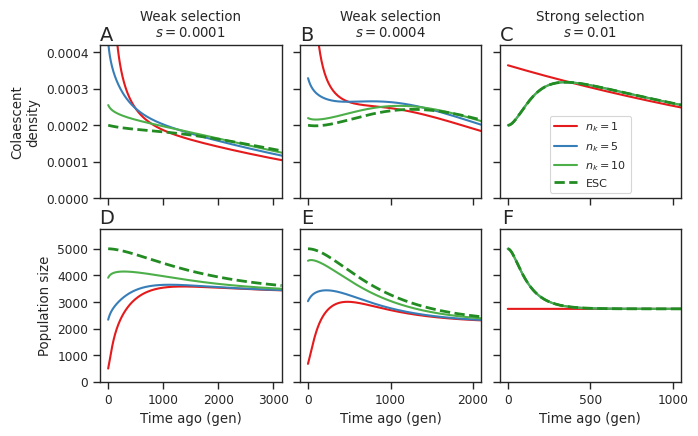

In [12]:
sns.set(style="ticks", context="paper", font_scale=1.0)

my_colors = """
#e41a1c
#377eb8
#4daf4a
""".split()

nrows, ncols = 2, 3

# fig = plt.figure(figsize=(7.5, 8.75))  # max dimension (PLOS ONE)
figsize_scale = 1
fig_1 = plt.figure(figsize=(7.5 * figsize_scale, 4.375 * figsize_scale))
gs = fig_1.add_gridspec(nrows=nrows, ncols=ncols, hspace=0.2, wspace=0.1)

# rows for s variable, U variable, N variable: create ax objects
axs = np.empty((nrows, ncols), dtype=object)
for i, j in np.ndindex(axs.shape):
    axs[i, j] = fig_1.add_subplot(gs[i, j])


for (i, j), ax in np.ndenumerate(axs):
    # coaldens
    if i == 0:
        # add
        for samid in range(df_popsize_list[j].shape[1]):
            coaldens_ = df_coaldens_list[j].iloc[:, samid]
            
            ax.plot(
                coaldens_.index,
                coaldens_.values,
                label=f"$n_k={coaldens_.name}$",
                color=my_colors[samid],
                linewidth=1.5,
            )

        # stepping_stone
        coaldens_stepstone = coal_dens_stepstone_list[j]
        
        ax.plot(
            time_psi,
            coaldens_stepstone,
            label=f"ESC",
            color="forestgreen",
            linestyle="dashed",
            linewidth=2
        )        

        if j == 0:
            ax.set_xlim(-0.05 * 3_000, 1.05 * 3_000)
            ax.set_ylim(0, 1.05 * 0.0004)
            #ax.set_title("$s=1 \cdot 10^{-4}$")
            ax.set_title("Weak selection\n$s = 0.0001$")
        elif j == 1:
            ax.set_xlim(-0.05 * 2_000, 1.05 * 2_000)
            ax.set_ylim(0, 1.05 * 0.0004)
            #ax.set_title("$s=4 \cdot 10^{-4}$")
            ax.set_title("Weak selection\n$s = 0.0004$")
        elif j == 2:
            ax.set_xlim(-0.05 * 1_000, 1.05 * 1_000)
            ax.set_ylim(0, 1.05 * 0.0004)
            ax.set_title("Strong selection\n$s=0.01$")
            ax.legend(fontsize=8, loc='lower center')

        if j == 0:
            ax.set_ylabel("Colaescent\ndensity")

    
    # popsize
    if i == 1:
        for samid in range(df_popsize_list[j].shape[1]):
            popsize_ = df_popsize_list[j].iloc[:, samid]
            
            ax.plot(
                popsize_.index,
                popsize_.values,
                label=f"$n_k={coaldens_.name}$",
                color=my_colors[samid],
                linewidth=1.5,
            )

        # stepping_stone
        popsize_stepstone = effective_popsize_stepstone_list[j]
        
        ax.plot(
            time_full,
            popsize_stepstone,
            label=f"ESC",
            color="forestgreen",
            linestyle="dashed",
            linewidth=2
        )
                
        if j == 0:
            ax.set_xlim(-0.05 * 3_000, 1.05 * 3_000)
        elif j == 1:
            ax.set_xlim(-0.05 * 2_000, 1.05 * 2_000)
        elif j == 2:
            ax.set_xlim(-0.05 * 1_000, 1.05 * 1_000)
            
        ax.set_ylim(0, 1.15 * 5000)

        ax.set_xlabel("Time ago (gen)")
        if j==0:
            ax.set_ylabel("Population size")


# labels
index = -1
for (i, j), ax in np.ndenumerate(axs):
    index += 1
    ax.text(
        .075,
        1.13,
        string.ascii_uppercase[index],
        transform=ax.transAxes,
        fontsize=14,
        va="top",
        ha="right",
    )

    if i == 0:
        ax.set_xticklabels([])

    if j > 0:
        ax.set_yticklabels([])


#plt.tight_layout()

plt.show()
plt.close()

### Pairsam

In [13]:
path = "pipeline_data_figure6/v01/results/pairsam/*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
# print(np.array(sorted_filenames))
_ = [print(_, __) for _, __ in enumerate(sorted_filenames, start=1)]

1 pipeline_data_figure6/v01/results/pairsam/popsize_5000,delmutrate_0.006,selcoeff_1e-4.gzip
2 pipeline_data_figure6/v01/results/pairsam/popsize_5000,delmutrate_0.006,selcoeff_4e-4.gzip
3 pipeline_data_figure6/v01/results/pairsam/popsize_5000,delmutrate_0.006,selcoeff_1e-2.gzip


In [14]:
my_colors = """
#b2182b
#ef8a62
darkgray
#d1e5f0
#67a9cf
#2166ac
gray
""".split()

In [15]:
mutload_maps = []
_N_list, _s_list, _U_list = [], [], []
df_popsize_list, df_coaldens_list = [], []
demographic_type_list = []
colid_p_list = []
for fid, f in enumerate(sorted_filenames):
    if fid == 2:
        time_threshold = 1000
    else:
        time_threshold = 5000
    (
        N_,
        s_,
        U_,
        colid_popsize,
        colid_coaldens,
        colid_p,
        demographic_type,
        load_mean,
        load_dist,
        df_popsize,
        df_coaldens,
    ) = pairsam_bias(sorted_filenames[fid], time_threshold=time_threshold)

    # change name
    demographic_type = [_ if _ != "Local-bias" else "Boom-bust" for _ in demographic_type]
    

    mutload_map = pd.DataFrame(
        {
            "demographic_cat": demographic_type,
            "load_mean": load_mean,
            "load_dist": load_dist,
            "p": np.array(colid_p)
        }
    )
   
    mutload_maps.append(mutload_map)
    df_popsize_list.append(df_popsize)
    df_coaldens_list.append(df_coaldens)
    demographic_type_list.append(demographic_type)
    colid_p_list.append(colid_p)
    _N_list.append(N_)
    _s_list.append(s_)
    _U_list.append(U_)

In [16]:
counts_list = []
for d_, p_ in zip(demographic_type_list, colid_p_list):
    counts = {dtype_: 0 for dtype_ in np.unique(d_)}
    for _d, _p in zip(d_, p_):
        counts[_d] += _p
    
    counts_list.append(counts)

### Visualisation

/tmp/ipykernel_214000/471885142.py:14: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_214000/471885142.py:14: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_214000/471885142.py:14: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


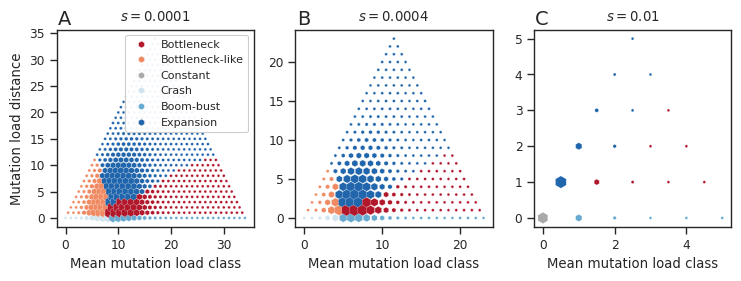

In [17]:
sns.set(context="paper", style="ticks")
fig_2, ax = plt.subplots(1, 3, figsize=(7.5, 3.5))

demography_order = [
    "Bottleneck",
    "Bottleneck-like",
    "Constant",
    "Crash",
    "Boom-bust",
    "Expansion",
]

def _add_plot(mutload_map, demography_order, ax):
    sns.scatterplot(
        data=mutload_map,
        x="load_mean",
        y="load_dist",
        hue="demographic_cat",
        size="p",
        sizes=(5, 80),
        hue_order=demography_order,
        style=100,
        palette=my_colors,
        markers="h",
        legend="brief",
        ax=ax,
    )
    
    ax.set_xlabel("Mean mutation load class")
    ax.set_ylabel("Mutation load distance")
    
    # Manually create a legend with only color entries
    handles, labels = ax.get_legend_handles_labels()
    color_legend = ax.legend(
        handles[1 : len(demography_order)+1],
        demography_order,
        title="Demographic Category",
        fontsize=8,
        framealpha=0.95
    )
    color_legend.set_title(None)
    
    ax.set_aspect("equal", adjustable="box")

for i, mutload_map in enumerate(mutload_maps):
    _add_plot(mutload_map, demography_order, ax[i])
    ax[i].set_title(f"$s={_s_list[i]}$")

    if i != 0:
        ax[i].legend().remove()

    ax[i].text(
        0.075,
        1.1,
        string.ascii_uppercase[i],
        transform=ax[i].transAxes,
        fontsize=14,
        va="top",
        ha="right",
    )

    if i >= 1:
        ax[i].set_ylabel(None)

    
plt.tight_layout()
plt.show()
plt.close()

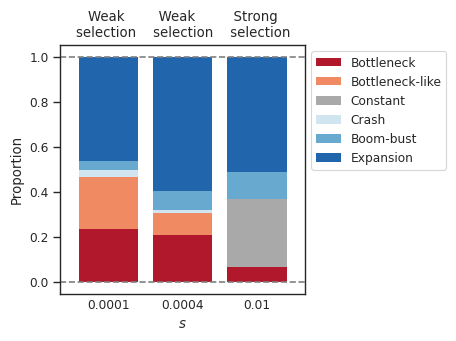

In [18]:
my_colors = """
#b2182b
#ef8a62
darkgray
#d1e5f0
#67a9cf
#2166ac
gray
""".split()

demography_order = [
    "Bottleneck",
    "Bottleneck-like",
    "Constant",
    "Crash",
    "Boom-bust",
    "Expansion",
]


dtype_freqs = pd.DataFrame(counts_list, index=np.array(_s_list).astype(str)).fillna(0)[demography_order]


sns.set(context="paper", style="ticks")
#fig_3, ax = plt.subplots(figsize=(3.65, 2.5))
fig_3, ax = plt.subplots(figsize=(4.65, 3.5))

ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(1, linestyle="dashed", color="gray")

dtype_freqs.plot.bar(
    stacked=True,
    linewidth=0,
    color=my_colors,
    width=0.8,
    ax=ax,
)

ax.set_xlabel("$s$")
ax.set_ylabel("Proportion")
ax.set_title("Weak        Weak         Strong\n"+
            "selection    selection    selection")

ax.tick_params(axis=u'x', which=u'both', rotation=0, length=0)
ax.set_ylim(-.05, 1.05)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.show()
plt.close()

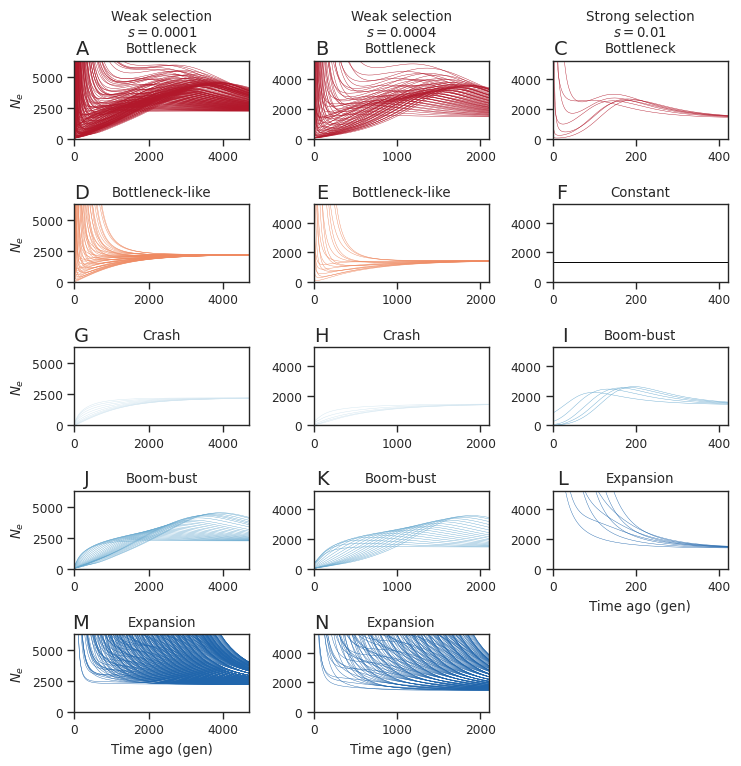

In [19]:
sns.set(context="paper", style="ticks")
fig_4, ax = plt.subplots(6, 3, figsize=(7.5, 8.75))

demography_order = [
    "Bottleneck",
    "Bottleneck-like",
    "Constant",
    "Crash",
    "Boom-bust",
    "Expansion",
]

my_colors = [_ if _ != "darkgray" else "black" for _ in my_colors]

index = -2
i = -1
for _df in df_popsize_list:
    index += 1
    i += 1
    j = -1
    for d_ in demography_order:
        index += 1
        j += 1
        for k, col in enumerate(_df.columns):
            j_, i_ = j, i
            if demographic_type_list[i][k] == d_:
                if j >= 2:
                    if i in [0, 1]:
                        j_ -= 1
                if i == 2:
                    if j > 1:
                        j_ -= 1
                    if j > 3:
                        j_ -= 1
                if my_colors[j] == "black":
                    ax[j_, i_].plot(_df.index, _df[col], color=my_colors[j], linewidth=0.7, alpha=1)
                else:
                    ax[j_, i_].plot(_df.index, _df[col], color=my_colors[j], linewidth=0.3, alpha=1)
                if j_ == 0:
                    if i_ == 0:
                        ax[j_, i_].set_title("Weak selection\n$s=0.0001$\n" + d_)
                    elif i_ == 1:
                        ax[j_, i_].set_title("Weak selection\n$s=0.0004$\n" + d_)
                    elif i_ ==2:
                        ax[j_, i_].set_title("Strong selection\n$s=0.01$\n" + d_)
                else:
                    ax[j_, i_].set_title(d_)
                if i == 0:
                    ax[j_, i_].set_xlim(0, 4500 * 1.05)
                    ax[j_, i_].set_ylim(0, 6000 * 1.05)
                if i == 1:
                    ax[j_, i_].set_xlim(0, 2000 * 1.05)
                    ax[j_, i_].set_ylim(0, 5000 * 1.05)
                if i == 2:
                    ax[j_, i_].set_xlim(0, 400 * 1.05)
                    ax[j_, i_].set_ylim(0, 5000 * 1.05)

                if j == 5:
                    ax[j_, i_].set_xlabel("Time ago (gen)")


# remove panels
ax[5, 0].remove()
ax[5, 1].remove()
ax[5, 2].remove()
ax[4, 2].remove()

for j in range(6):
    ax[j, 0].set_ylabel("$N_e$")


index = -1
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        index += 1
        ax[i, j].text(
            0.085,
            1.275,
            string.ascii_uppercase[index],
            transform=ax[i, j].transAxes,
            fontsize=14,
            va="top",
            ha="right",
        )


plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_214000/3918059539.py:21: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_214000/3918059539.py:21: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_214000/3918059539.py:21: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


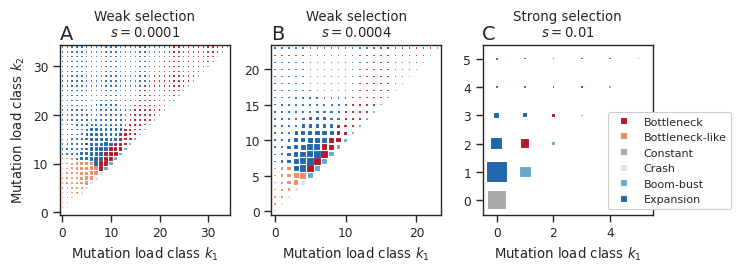

In [21]:
# Alternative Image for figure 0.7
sns.set(context="paper", style="ticks")
fig_2, ax = plt.subplots(1, 3, figsize=(7.5, 3.5))

my_colors = [_ if _ != "black" else "darkgray" for _ in my_colors]

demography_order = [
    "Bottleneck",
    "Bottleneck-like",
    "Constant",
    "Crash",
    "Boom-bust",
    "Expansion",
]

def _add_plot(mutload_map, demography_order, ax, sizes=(1, 30)):
    # add sampled fitness classes
    mutload_map["h1"] = (mutload_map["load_mean"] - 0.5 * mutload_map["load_dist"]).astype(int)
    mutload_map["h2"] = (mutload_map["load_mean"] + 0.5 * mutload_map["load_dist"]).astype(int)
  
    sns.scatterplot(
        data=mutload_map,
        x="h1",
        y="h2",
        hue="demographic_cat",
        size="p",
        sizes=sizes,
        hue_order=demography_order,
        style=100,
        palette=my_colors,
        markers="s",
        legend="brief",
        ax=ax,
    )
    
    ax.set_xlabel("Mutation load class $k_1$")
    ax.set_ylabel("Mutation load class $k_2$")

    ax.set_xlim(-.5, max(mutload_map["h1"])+.5)
    ax.set_ylim(-.5, max(mutload_map["h2"])+.5)
    
    # Manually create a legend with only color entries
    handles, labels = ax.get_legend_handles_labels()
    color_legend = ax.legend(
        handles[1 : len(demography_order)+1],
        demography_order,
        title="Demographic Category",
        fontsize=8,
        framealpha=0.95,
        bbox_to_anchor=(1.1, 0),
        loc='lower center'
    )
    color_legend.set_title(None)
    
    ax.set_aspect("equal", adjustable="box")

for i, mutload_map in enumerate(mutload_maps):
    if i == 0:
        _par = {"sizes": (1, 10)}
    elif i == 1:
        _par = {"sizes": (1, 25)}
    elif i == 2:
        _par = {"sizes": (1, 200)}
    _add_plot(mutload_map, demography_order, ax[i], **_par)

    # Set titles
    if i == 0:
        ax[i].set_title(f"Weak selection\n$s={_s_list[i]}$")
    elif i == 1:
        ax[i].set_title(f"Weak selection\n$s={_s_list[i]}$")
    elif i == 2:
        ax[i].set_title(f"Strong selection\n$s={_s_list[i]}$")


    if i != 2:
        ax[i].legend().remove()

    ax[i].text(
        0.075,
        1.1235,
        string.ascii_uppercase[i],
        transform=ax[i].transAxes,
        fontsize=14,
        va="top",
        ha="right",
    )

    if i >= 1:
        ax[i].set_ylabel(None)



fig_2.tight_layout()
#plt.tight_layout()
plt.show()
plt.close()

## Save data and figure

In [22]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure6_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure6_v{version:02d}.png"

plt.figure(fig_1)
plt.savefig(new_filename, dpi=600)
plt.close()

In [23]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure7_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure7_v{version:02d}.png"

plt.figure(fig_2)
plt.savefig(new_filename, dpi=600)
plt.close()

In [24]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure7S1_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure7S1_v{version:02d}.png"

plt.figure(fig_3)
plt.savefig(new_filename, dpi=600)
plt.close()

In [25]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure7S2_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure7S2_v{version:02d}.png"

plt.figure(fig_4)
plt.savefig(new_filename, dpi=600)
plt.close()